In [1]:
# Importing the required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import StepLR

In [2]:
# Setting device to cuda if possible to optimize the performance
# by using GPU instead of CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [3]:
# CA rules:
# Number of alive neighbors that suffice CA rule set
neighbors_max, neighbors_min = 3, 2
# Number of states in the CA
states = 2

# Kernel options:
# Filter(kernel) size used in layer convolutions
filter_size = 3
# Singular value of padding used in the circular_pad functionof ScanLayer
pad_div = (filter_size - 1) // 2
# Combined variable used in the circular_pad function of ScanLayer
custom_padding = (pad_div, pad_div, pad_div, pad_div)

# Batch options:
# Sample size and dimensions on the samples
sample_size, grid_width, grid_height = 500, 10, 10


In [4]:
class ScanLayer(nn.Module):
    def forward(self, x):
        # Applying circular pad function to the input tensor x.
        padded_x = self.circular_pad(x, padding=custom_padding)
        return padded_x
    
    def circular_pad(self, x, padding):
        top, bottom, left, right = padding
        # Pad the input tensor along verical axis
        padded_x = torch.cat([x[:, :, -top:, :], x, x[:, :, :bottom, :]], dim=2)
        # Pad the input tensor along horizontal axis
        padded_x = torch.cat([padded_x[:, :, :, -left:], padded_x, padded_x[:, :, :, :right]], dim=3)
        return padded_x

In [5]:
class CAModel(nn.Module):
    def __init__(self):
        super(CAModel, self).__init__()
        
        # Total number of layers and neurons per layer
        layers_total = 3
        neurons = 100

        # Array containing all of the layers
        layers = []

        # Appending ScanLayer and first convolutional layer
        layers.append(ScanLayer())
        layers.append(nn.Conv2d(2, neurons, kernel_size=filter_size))
        layers.append(nn.ReLU())

        # Appending the rest of the convolutional layers, besides the final one
        for i in range(layers_total - 2):
            layers.append(nn.Conv2d(neurons, neurons, kernel_size=1))
            layers.append(nn.ReLU())
        
        # Appending the final convolutional layer
        layers.append(nn.Conv2d(neurons, 2, kernel_size=1))

        # Grouping layers from the array into the sequence
        self.layers = nn.Sequential(*layers)

    # Forward pass of the model, running the input tensor through
    # the layers of neural network
    def forward(self, x):
        return self.layers(x)


In [6]:
# Create an instance of the CAModel.
model = CAModel()
model = model.to(device)
# Scan layer and 12 Conv2d layers of hundred neurons, followed
# by RelU activation function
print(model)

CAModel(
  (layers): Sequential(
    (0): ScanLayer()
    (1): Conv2d(2, 100, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(100, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [7]:
# Define a function for augmenting a 2D grid using a cellular automaton rule.
def augment(X, max, min, filter_size):
    # Convolve the input grid X with a filter of ones to count neighbors.
    neighbors = convolve2d(X, np.ones((filter_size, filter_size)), mode='same', boundary='wrap') - X
    # Create a new grid by applying the cellular automaton rule:
    # - If a cell has exact number of neighbors(equals to 'max' variable), it becomes alive.
    # - If a cell is alive and number of neighbors equals to 'min'
    return np.logical_or(neighbors == max, np.logical_and(X, neighbors == min))

In [8]:
# Generating initial batch of samples that would be modified and used for model training
X_pre = np.random.choice([0, states-1], size=(sample_size, grid_width, grid_height))

# Applying 'augment' function to all of the samples of X_pre in order 
# to apply one step of 'evolution' of the CA and converting it to tensor
# cells_alive, cells_dead and filter_size parameters are used to modify the rules of CA-augmentation
Y_pre = np.stack([augment(d, neighbors_max, neighbors_min, filter_size) for d in X_pre])
Y_augmented = torch.tensor(Y_pre, dtype=torch.long).to(device)

# Creating negated complement array to X_pre in order to maximize generalization and converting it to tensor
X_neg = 1 - X_pre
X_pre = np.stack([X_neg, X_pre], axis=1)
X_train = torch.tensor(X_pre, dtype=torch.float32).to(device)

In [9]:
# A shape of sample_size x 2 x grid_width x grid_height, whereas 1D represents the batch size, 
# 2D - two complemented versions of X_train
# and the last two dimensions are the dimension of the grid
print(X_train.shape)

# A shape of sample_size x grid_width x grid_height, generally the same as for X_train, 
# excluding the complemented version
print(Y_augmented.shape)

torch.Size([500, 2, 10, 10])
torch.Size([500, 10, 10])


In [10]:
# Number of training epochs
epochs = 500
# Initial learning rate
learning_rate = 0.01
# Learning step size for the scheduler
lr_step_size = epochs/4
# Gamma factor for scheduler to change the learning rate
lr_gamma = 0.5
# Setting up an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Setting up the learning rate scheduler given the variables defined before
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
# Assigning the loss function, CrossEntropyLoss in this case
criterion = nn.CrossEntropyLoss()
# Array to store the loss values
losses = np.zeros(epochs)

In [11]:
# Training loop
for epoch in range(epochs):
    # Forward pass: compute predicted y by passing X_train through the model
    y_predicted = model(X_train)
    # Compute the loss between the predicted y and the ground truth Y_train
    loss = criterion(y_predicted, Y_augmented)
    # Store the loss value for the current epoch
    losses[epoch] = loss.item()

    # Zero the gradients accumulated in the previous iteration
    optimizer.zero_grad()
    # Backpropagation: compute gradients of the loss with respect to model parameters
    loss.backward()
    # Update the model parameters using the computed gradients
    optimizer.step()
    
    # Adjust the learning rate based on the learning rate scheduler
    scheduler.step()

# The training loop completes after all epochs have been processed

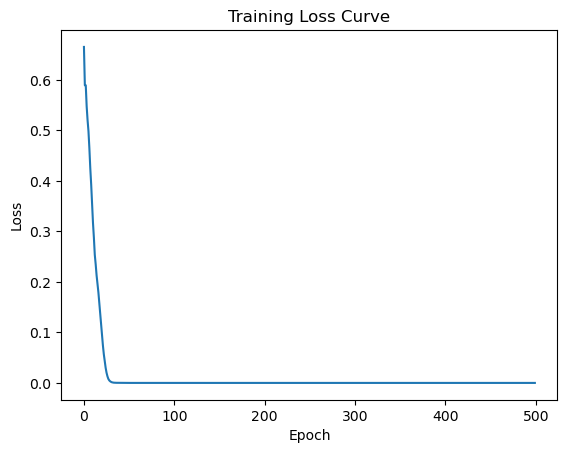

Last loss: 2.9165837531763827e-06


In [12]:
# Plotting the losses graph based on the training loop
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()
print(f"Last loss: {losses[-1]}")

In [13]:
# Saving model to a file
save_path = 'model.pth'
torch.save(model.state_dict(), save_path)

(-0.5, 49.5, 49.5, -0.5)

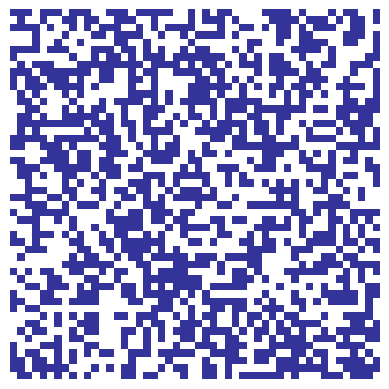

In [14]:
# Game of Life Beacon:
#val_figure = np.array([[0,0,0,0,0,0],
#                      [0,1,1,0,0,0],
#                      [0,1,0,0,0,0],
#                      [0,0,0,0,1,0],
#                      [0,0,0,1,1,0],
#                      [0,0,0,0,0,0]])

# Randomly generated grid
val_figure = np.random.choice([0, states-1], size=(50, 50)) 

# Plotting validation grid
plt.imshow(val_figure, cmap='terrain')
plt.axis("off")

In [15]:
# Validation data preparation for CNN architecture CA
gen0 = val_figure
cnn_val = np.stack([1 - gen0, gen0])
cnn_val = torch.from_numpy(cnn_val).float().unsqueeze(0).to(device)
cnn_val_gen0 = cnn_val

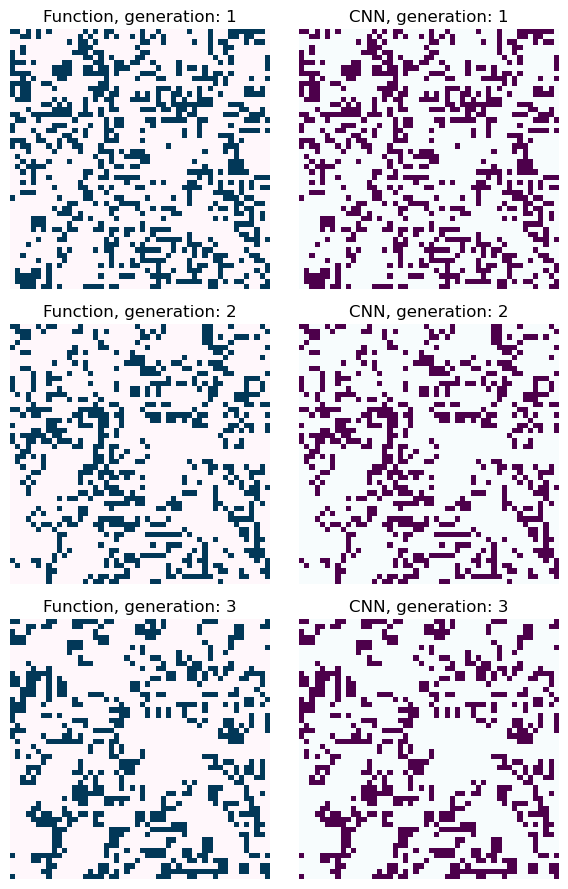

In [16]:
# Plotting the comparison between 'augment' function and CA-CNN outcomes
num_plots = 3

num_rows = num_plots
num_cols = 2

figsize = (6, 3 * num_rows)

fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)

# Ensuring correct number of dimensions for only one row of examples
if num_rows == 1:
    ax = np.expand_dims(ax, axis=0)

# Loop that takes validation data through both of the CA architectures
for k in range(num_plots):
    val_figure = augment(val_figure, 3, 2, 3)
    ax[k, 0].imshow(val_figure, cmap="PuBu")
    ax[k, 0].set_title('Function, generation: ' + str(k + 1))
    ax[k, 0].axis('off')

    cnn_val = torch.softmax(model(cnn_val), dim=1)
    ax[k, 1].imshow(cnn_val.cpu().detach().numpy()[0, 0], cmap="BuPu_r")
    ax[k, 1].set_title('CNN, generation: ' + str(k + 1))
    ax[k, 1].axis('off')

plt.tight_layout()
plt.show()

# Resetting validation data to initial state
val_figure = gen0
cnn_val = cnn_val_gen0